In [1]:
library("ggplot2")
library("reshape2")
library("tidyverse")
library("data.table")
knitr::opts_chunk$set(echo = TRUE)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:reshape2’:

    dcast, melt




## Our first classifier!

\[reminder: classifier = predictive machine for classification problems \]

### Reading the data

For this practical session on logistic regression we are using a dataset on the relationship between cleft lip in dogs (Nova Scotia Duck Tolling Retriever, NSDTR) and SNP genotypes ([data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.j8r8q); [paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005059)).

The public dataset downloaded from Dryad is a *Plink* `.tped/.tfam` file. The data have been preprocessed:

- filtered (SNP quality, call-rate, MAF)
- imputed (imputation of missing genotypes using LHCI: localised haplotype-clustering imputation)
- selected (only SNPs on chromosomes 25, 26, 27, 28, 29)

We begin by using a reduced version of the dataset, where $0.5\%$ of the SNP loci have been randomly picked: 

In [2]:
dogs <- fread("../data/dogs_imputed_reduced.raw")
dogs <- dogs %>%
  select(-c(IID,FID,PAT,MAT,SEX))

## values for logistic regression in glm() must be 0 - 1
dogs$PHENOTYPE = dogs$PHENOTYPE-1
head(dogs)
print(nrow(dogs))
print(ncol(dogs)-1)

PHENOTYPE,chr25.11293074_A,chr25.19440033_G,chr25.23946569_A,chr25.24073769_C,chr25.50815850_A,chr25.52465894_G,chr26.3008718_T,chr26.4305281_G,chr26.5245240_A,⋯,chr29.16492959_A,chr29.20943818_T,chr29.23503804_A,chr29.24525289_T,chr29.29116808_C,chr29.30958662_G,chr29.32818481_C,chr29.36491804_T,chr29.37724282_T,chr29.39749180_C
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,1,1,0,1,1,0,1,⋯,0,0,0,0,0,1,1,1,0,0
1,0,0,0,1,0,1,2,1,1,⋯,1,0,0,2,1,0,1,1,0,0
0,0,0,1,2,0,0,0,0,0,⋯,1,1,1,1,0,0,0,0,0,0
0,0,1,0,1,0,0,1,1,0,⋯,0,0,0,1,0,0,0,0,0,0
0,1,1,0,0,0,1,0,0,0,⋯,0,0,0,0,0,1,1,0,1,0
1,0,0,0,1,0,0,2,1,1,⋯,0,0,0,1,0,1,2,1,0,0


[1] 125
[1] 45


The dataset contains data on `r nrow(dogs)` and `r ncol(dogs)-2` SNP genotypes.
Controls (dogs without cleft lip) are coded as `1`'s, cases (dogs with cleft lip) are coded as `2`'s:

In [3]:
dogs %>%
  group_by(PHENOTYPE) %>%
  summarise(N=n())

PHENOTYPE,N
<dbl>,<int>
0,112
1,13


In [4]:
maf_controls <- colSums(dogs[dogs$PHENOTYPE==0,-c(1,2)])/(2*nrow(dogs[dogs$PHENOTYPE==0,]))
maf_cases <- colSums(dogs[dogs$PHENOTYPE==1,-c(1,2)])/(2*nrow(dogs[dogs$PHENOTYPE==1,]))

No id variables; using all as measure variables



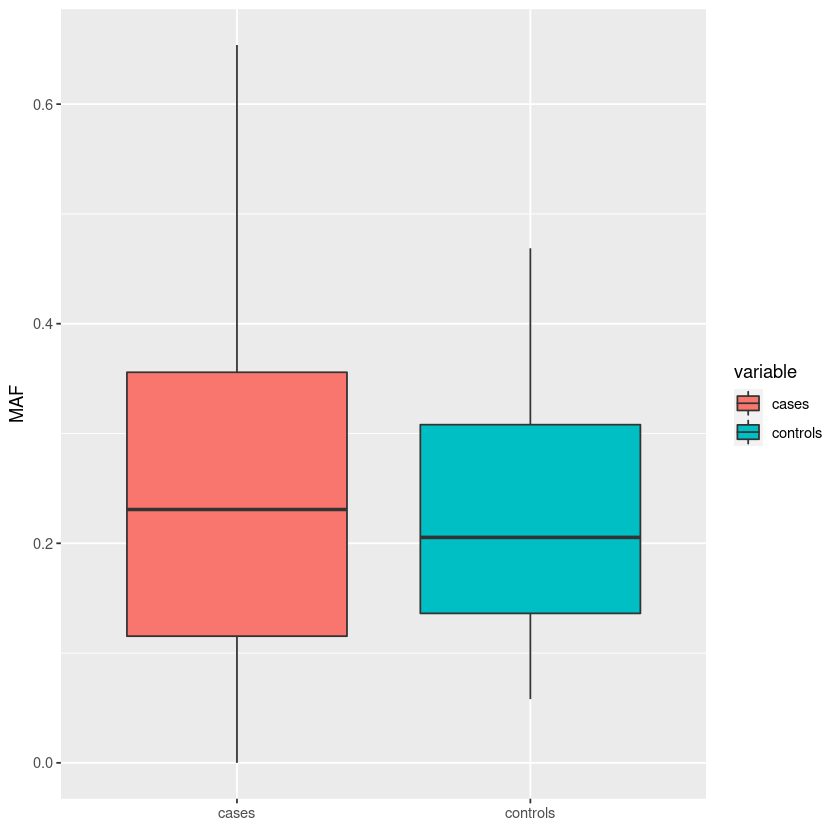

In [5]:
maf <- data.frame("cases"=maf_cases, "controls"=maf_controls)
mD <- reshape2::melt(maf)
ggplot(mD, aes(y = value, x = variable)) + geom_boxplot(aes(fill=variable)) + xlab(element_blank()) + ylab("MAF")

## Fitting the logistic regression model

We now split the data into training and test set, and then fit the logistic regression model to the training set.
We have an **unbalanced binomial dataset** (13 cases, 112 controls, tot = 125), therefore we may want to keep the same proportion of cases adn controls when sampling the training and the test sets. To do so, we can use what is called "**stratified sampling**":


In [6]:
seed = 121
set.seed(seed)

dogs$id <- paste("id",seq(1,nrow(dogs)), sep="_")

training_set <- dogs %>%
  group_by(PHENOTYPE) %>%
  sample_frac(size = 0.7)

test_recs <- !(dogs$id %in% training_set$id)
test_set <- dogs[test_recs,]

training_set$id <- NULL
test_set$id <- NULL

table(training_set$PHENOTYPE)
table(test_set$PHENOTYPE)


 0  1 
78  9 


 0  1 
34  4 

In *R*, you can use the function `glm()` (generalised linear model) that allows you to specify the distribution (binomial in this case) and the link function (logit, in this case).

In [7]:
glm.fit <- glm(PHENOTYPE ~ ., data = training_set, family=binomial(link="logit"))

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


## Making predictions

To make predictions, we apply the fitted model to the test data. We get probabilities of being a case ($$p(y=1|x)$$), and we need to set a threshold to discriminate between cases (1's) and controls (0's): a common choice for the threshold is **0.5**. 

In [8]:
glm.probs <- predict(glm.fit, newdata = test_set[,-1],type="response") 
glm.pred <- ifelse(glm.probs > 0.5, 1, 0)
table(glm.pred,test_set$PHENOTYPE)

        
glm.pred  0  1
       0 28  3
       1  6  1

In [10]:
error = mean(glm.pred!=test_set$PHENOTYPE)
accuracy = 1 - error
print(accuracy)

[1] 0.7631579


The error rate is `r round(error,4)`; equivalently we can express this as accuracy (1-error rate) `r round(accuracy,3)`

In [11]:
TER = sum(glm.pred != test_set$PHENOTYPE)/length(glm.pred)
TP = sum(glm.pred == 1 & test_set$PHENOTYPE == 1)
FN = sum(glm.pred == 0 & test_set$PHENOTYPE == 1)
TN = sum(glm.pred == 0 & test_set$PHENOTYPE == 0)
FP = sum(glm.pred == 1 & test_set$PHENOTYPE == 0)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)
print(FPR)
print(FNR)

[1] 0.1764706
[1] 0.75


False postive rate is `r FPR`, false negative rate is `r FNR`

## Exercise 4.1

- implement k-fold cross-validation to assess the performance of the logistic regression model:

In [ ]:
n = nrow(dogs)
k = 0

In [ ]:
## continue with your code here

## ROC curves

We use the same training/test split as above:

In [ ]:
glm.fit <- glm(PHENOTYPE ~ ., data = training_set, family=binomial(link="logit"))

glm.probs <- predict(glm.fit, newdata = test_set[,-1],type="response") 
glm.pred <- ifelse(glm.probs > 0.5, 1, 0)
table(glm.pred,test_set$PHENOTYPE)

In [ ]:
library("ROCit")

ROCit_logit <- rocit(score=glm.probs,class=test_set$PHENOTYPE)
plot(ROCit_logit)
save(ROCit_logit, file = "ROClogit.RData") ## saving results in a local file